In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_normal = pd.read_csv("./full_used_data/normal_clips_with_info.csv")
df_abnormal = pd.read_csv("./full_used_data/abnormal_clips_with_info.csv")
pairs = pd.read_csv("./full_used_data/pairs_action_with_info.csv")

In [ ]:
numeric_cols = df_normal.columns[1:61]
used_normal_video = pairs["normal_video_key"].unique().tolist()
df_normal_paired = df_normal[df_normal['prefix'].isin(used_normal_video)].copy()
df_normal = df_normal[~df_normal['prefix'].isin(used_normal_video)]

# 計算未配對正常組的 z score

In [ ]:
condition = (
    ((df_normal['month'] == 5) & (df_normal['action_type'] == 'general')) |
    (df_normal['month'].isin([6, 8]))
)

# 篩選後的資料
df_normal_unpaired_z = df_normal[condition][['filename', 'prefix', 'age', 'action_type', 'month']].copy()

# 對指定欄位做 z-score 標準化
df_normal_unpaired_z[numeric_cols] = df_normal.loc[condition, numeric_cols].apply(
    lambda x: (x - x.mean()) / x.std(), axis=0
)

df_normal_unpaired_z

In [ ]:
df_normal_unpaired_z[numeric_cols] = df_normal_unpaired_z[numeric_cols].round(4)
df_normal_unpaired_z.to_csv("./full_used_data/normal_clips_with_info_z_new_unpaired.csv", index=False)

# 計算配對資料之 z score

In [ ]:
# 1. 計算 normal 組的 mean 和 std
normal_stats = df_normal.groupby(['month', 'action_type'])[numeric_cols].agg(['mean', 'std']).reset_index()
# 攤平成單層欄位名稱
normal_stats.columns = ['month', 'action_type'] + [f'{col}_{stat}' for col in numeric_cols for stat in ['mean', 'std']]

# 2. 將 normal 的 mean/std merge 到 abnormal
# 先建立一個對應的 mean/std 欄位名稱
mean_cols = [f'{col}_mean' for col in numeric_cols]
std_cols = [f'{col}_std' for col in numeric_cols]

df_abnormal_merged = df_abnormal.merge(normal_stats, on=['month', 'action_type'], how='left')

# 3. 計算 z score
z_scores = (df_abnormal_merged[numeric_cols].values - df_abnormal_merged[mean_cols].values) / df_abnormal_merged[std_cols].values
# 轉成 DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=numeric_cols)

# 4. 合併 meta 資訊
cols_meta = ['filename', 'prefix', 'age', 'action_type', 'month']
df_abnormal_z = pd.concat([df_abnormal_merged[cols_meta].reset_index(drop=True), z_scores_df.reset_index(drop=True)], axis=1)

In [ ]:
df_normal_merged = df_normal_paired.merge(normal_stats, on=['month', 'action_type'], how='left')

z_scores = (df_normal_merged[numeric_cols].values - df_normal_merged[mean_cols].values) / df_normal_merged[std_cols].values
z_scores_df = pd.DataFrame(z_scores, columns=numeric_cols)

df_normal_z = pd.concat([df_normal_merged[cols_meta].reset_index(drop=True), z_scores_df.reset_index(drop=True)], axis=1)

In [ ]:
# 將 z score 數值欄位 round 4
df_normal_z[numeric_cols] = df_normal_z[numeric_cols].round(4)
df_abnormal_z[numeric_cols] = df_abnormal_z[numeric_cols].round(4)

In [ ]:
df_abnormal_z.to_csv("./full_used_data/abnormal_clips_with_info_z.csv", index=False)
df_normal_z.to_csv("./full_used_data/normal_clips_with_info_z.csv", index=False)

# 將 clips 按照檔名排序

In [ ]:
df_normal_z = pd.read_csv("../20250615/full_used_data/normal_clips_with_info_z.csv")
df_abnormal_z = pd.read_csv("../20250615/full_used_data/abnormal_clips_with_info_z.csv")

In [ ]:
# 將影片按照編號排列
df_abnormal_z[['prefix', 'number']] = df_abnormal_z['filename'].str.rsplit('-', n=1, expand=True) 
df_abnormal_z['number'] = df_abnormal_z['number'].astype(int) 
df_abnormal_z = df_abnormal_z.sort_values(['prefix', 'number']).reset_index(drop=True)

df_normal_z[['prefix', 'number']] = df_normal_z['filename'].str.rsplit('-', n=1, expand=True) 
df_normal_z['number'] = df_normal_z['number'].astype(int) 
df_normal_z = df_normal_z.sort_values(['prefix', 'number']).reset_index(drop=True)

In [ ]:
abnormal_clip_counts = df_abnormal_z['prefix'].value_counts()
df_abnormal_z["clips"] = df_abnormal_z["prefix"].map(abnormal_clip_counts)

normal_clip_counts = df_normal_z['prefix'].value_counts()
df_normal_z["clips"] = df_normal_z["prefix"].map(normal_clip_counts)

In [ ]:
df_abnormal_z.loc[:, "label"] = 1
df_normal_z.loc[:, "label"] = 0
df = pd.concat([df_normal_z, df_abnormal_z], ignore_index=True)

In [ ]:
df.to_csv("./sorted_clips_with_info.csv", index=False)

# |z| 的篩選

In [ ]:
mask = (df['label'] == 1)
# 至少有一個 numeric_cols > 2
threshold = 2
numeric_mask = (df.loc[mask, numeric_cols].abs() > threshold).any(axis=1)
df_label1_filtered = df.loc[mask].loc[numeric_mask].copy()
df_label1_filtered

In [ ]:
# 合併 label 為 0 的資料與 df_label1_filtered
df_label0 = df[df['label'] == 0].copy()
df_filtered_merged = pd.concat([df_label0, df_label1_filtered], ignore_index=True)
df_filtered_merged.to_csv(f'./filtered_merged_{threshold}.csv', index=False)

# feature selection
根據每個年齡段不同 action_type，分別計算正常/不正常組的 z score 平均值，取差值最大的前五個

In [ ]:
df_abnormal_z = pd.read_csv("./full_used_data/abnormal_clips_with_info_z.csv")
df_normal_z = pd.read_csv("./full_used_data/normal_clips_with_info_z.csv")

In [ ]:
# 依據 month 與 action_type 分組，先取絕對值再計算每個 numeric_cols 欄位的平均值
abnormal_grouped_means = df_abnormal_z.groupby(['month', 'action_type'], observed=False)[numeric_cols].apply(lambda x: x.abs().mean())
normal_grouped_means = df_normal_z.groupby(['month', 'action_type'], observed=False)[numeric_cols].apply(lambda x: x.abs().mean())

abnormal_grouped_means_d = df_abnormal_z.groupby(['month', 'action_type'], observed=False)[numeric_cols].mean()
normal_grouped_means_d = df_normal_z.groupby(['month', 'action_type'], observed=False)[numeric_cols].mean()

In [ ]:
# 計算差值絕對值，顯示每組差值最大的五個欄位，並印出正常組與不正常組的 mean
for idx in abnormal_grouped_means.index:
    diff = (abnormal_grouped_means.loc[idx] - normal_grouped_means.loc[idx]).abs()
    top5 = diff.sort_values(ascending=False).head(5).round(4)
    print(f"month, action_type: {idx}")
    print("差值 (abs):")
    print(top5)
    print("abnormal mean:")
    print(abnormal_grouped_means_d.loc[idx, top5.index].round(4))
    # print(abnormal_grouped_means.loc[idx, top5.index].round(4))
    print("normal mean:")
    print(normal_grouped_means_d.loc[idx, top5.index].round(4))
    # print(normal_grouped_means.loc[idx, top5.index].round(4))
    print("-" * 30)

month, action_type: (5, 'general')
差值 (abs):
RShoulder_angular_velocities    1.4383
RWrist_centroid_of_motion_y     1.4245
RWrist_periodicity_x            1.3889
LShoulder_angular_velocities    1.2364
UpperLimb_Ama                   1.1140
Name: (5, general), dtype: float64
abnormal mean:
RShoulder_angular_velocities   -2.3213
RWrist_centroid_of_motion_y    -0.2578
RWrist_periodicity_x            0.1796
LShoulder_angular_velocities   -2.0329
UpperLimb_Ama                   1.4588
Name: (5, general), dtype: float64
normal mean:
RShoulder_angular_velocities   -0.2410
RWrist_centroid_of_motion_y     1.6823
RWrist_periodicity_x            0.3708
LShoulder_angular_velocities   -0.0339
UpperLimb_Ama                  -0.3448
Name: (5, general), dtype: float64
------------------------------
month, action_type: (6, 'general')
差值 (abs):
RHip_angular_velocities         0.4904
LShoulder_angular_velocities    0.4759
LHip_angular_velocities         0.4476
RElbow_angular_velocities       0.3841
LHip_

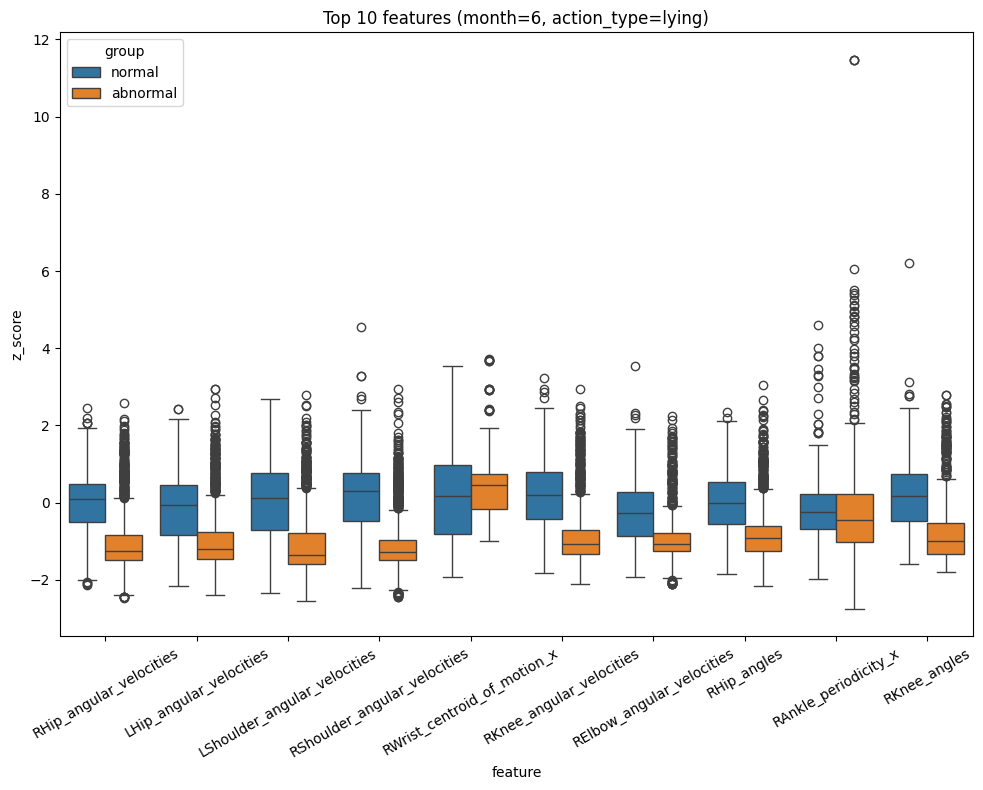

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 找出 month=6, action_type=general 的差值前十大的 numeric_cols
idx = (6, 'general')
diff = (abnormal_grouped_means.loc[idx] - normal_grouped_means.loc[idx]).abs()
top10_cols = diff.sort_values(ascending=False).head(10).index.tolist()

# 2. 取出這些欄位的 normal/abnormal 資料
normal_data = df_normal_z[(df_normal_z['month'] == 6) & (df_normal_z['action_type'] == 'general')][top10_cols]
abnormal_data = df_abnormal_z[(df_abnormal_z['month'] == 6) & (df_abnormal_z['action_type'] == 'general')][top10_cols]

normal_data['group'] = 'normal'
abnormal_data['group'] = 'abnormal'

plot_df = pd.concat([normal_data, abnormal_data], ignore_index=True)

# 3. melt 方便畫圖
plot_df_melt = plot_df.melt(id_vars='group', value_vars=top10_cols, var_name='feature', value_name='z_score')

plt.figure(figsize=(10, 8))
sns.boxplot(x='feature', y='z_score', hue='group', data=plot_df_melt)
plt.title('Top 10 features (month=6, action_type=lying)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()